<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

/tmp/ipython-input-1-503389760.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(binary_map)


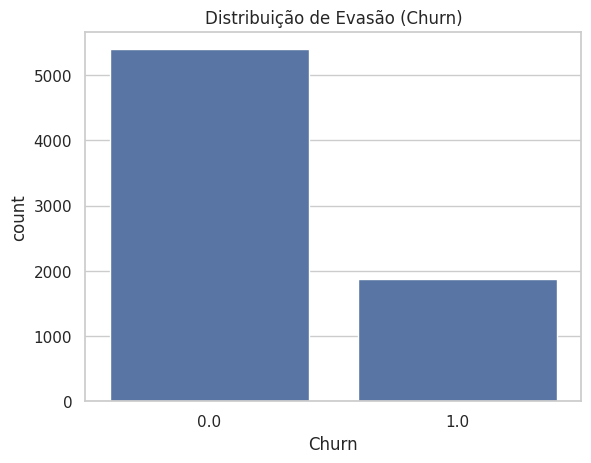

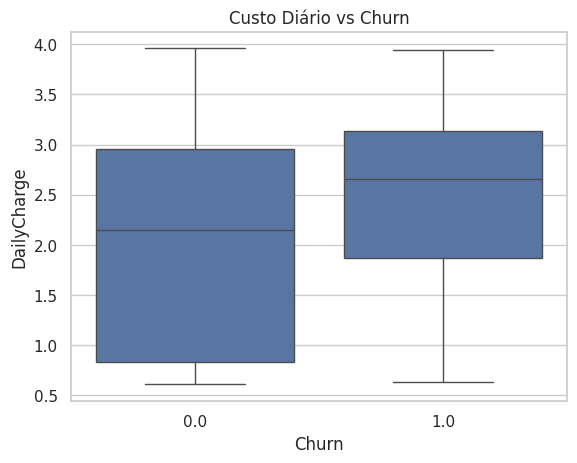

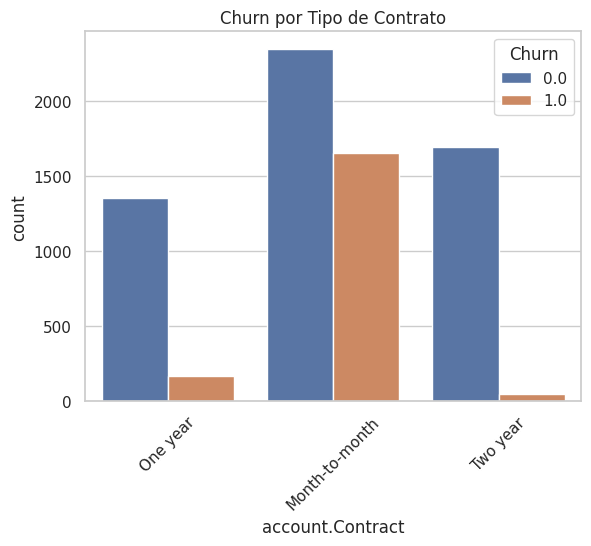

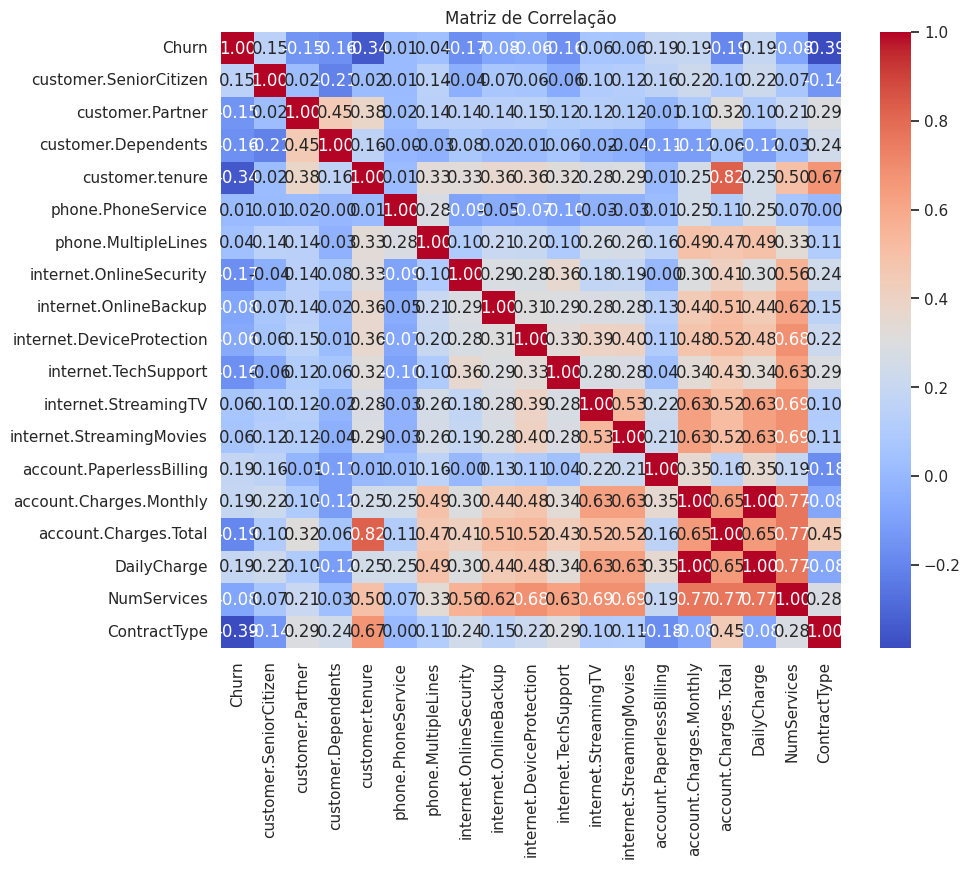


## Introdução

Este relatório tem como objetivo analisar os dados de clientes da TelecomX e identificar os principais fatores que influenciam o churn. A partir dessa análise, buscamos fornecer insights e recomendações estratégicas para reduzir a evasão e aumentar a retenção de clientes.

---

## Limpeza e Tratamento de Dados

- Conversão de colunas numéricas (`Charges.Total`, `Churn`)
- Padronização de valores binários (Yes/No para 1/0)
- Remoção de duplicatas
- Preenchimento de valores ausentes com a mediana

---

## Análise Exploratória de Dados

### Taxa de Evasão (Churn):
**25.72%**

### Custo Diário Médio:
- Não Churn: R\$ 2.05
- Churn: R\$ 2.48

### Serviços Contratados (média):
- Não Churn: 3.03
- Churn: 2.68

---

## Conclusões e Insights

1. Contratos mensais têm maior taxa de evasão.
2. Clientes com menos serviços são mais propensos a sair.
3. Custo diário mais alto aparece mais em clientes churn.

---

## Recomendações

- Promover contratos de maior duração com benefícios.
- Oferecer pacotes integrados para elevar o número de serviços.
- Monitorar clientes com custo elevado e pouco tempo de uso.


In [1]:
# TelecomX - Análise de Evasão de Clientes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from IPython.display import display, Markdown

sns.set(style="whitegrid")

url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.json_normalize(data)

df.info()
print("Linhas:", df.shape[0], "| Colunas:", df.shape[1])

# Conversão de colunas numéricas
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Mapear colunas binárias (Sim/Não ou Yes/No)
binary_map = {'Yes': 1, 'No': 0, 'Sim': 1, 'Não': 0, 'No internet service': 0, 'No phone service': 0}
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace(binary_map)

# Conversão definitiva de 'Churn' para numérico
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})
df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')

# Engenharia de Features
df['DailyCharge'] = df['account.Charges.Monthly'] / 30

service_cols = [
    'internet.OnlineSecurity','internet.OnlineBackup','internet.DeviceProtection',
    'internet.TechSupport','internet.StreamingTV','internet.StreamingMovies','phone.PhoneService'
]
df['NumServices'] = df[service_cols].sum(axis=1)

# Tipo de contrato numerificado
df['ContractType'] = df['account.Contract'].map({'Month-to-month':1, 'One year':2, 'Two year':3})

# Limpeza final de valores ausentes
df = df.drop_duplicates()
df.fillna(df.median(numeric_only=True), inplace=True)

# Visualizações e Análise

# Distribuição do churn
sns.countplot(x='Churn', data=df)
plt.title('Distribuição de Evasão (Churn)')
plt.show()

# Custo diário vs churn
sns.boxplot(x='Churn', y='DailyCharge', data=df)
plt.title('Custo Diário vs Churn')
plt.show()

# Churn por tipo de contrato
sns.countplot(x='account.Contract', hue='Churn', data=df)
plt.title('Churn por Tipo de Contrato')
plt.xticks(rotation=45)
plt.show()

# Correlação entre variáveis numéricas
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

# Relatório final

churn_rate = df['Churn'].mean()
daily_by_churn = df.groupby('Churn')['DailyCharge'].mean().to_dict()
services_by_churn = df.groupby('Churn')['NumServices'].mean().to_dict()

report = f'''
## Introdução

Este relatório tem como objetivo analisar os dados de clientes da TelecomX e identificar os principais fatores que influenciam o churn. A partir dessa análise, buscamos fornecer insights e recomendações estratégicas para reduzir a evasão e aumentar a retenção de clientes.

---

## Limpeza e Tratamento de Dados

- Conversão de colunas numéricas (`Charges.Total`, `Churn`)
- Padronização de valores binários (Yes/No para 1/0)
- Remoção de duplicatas
- Preenchimento de valores ausentes com a mediana

---

## Análise Exploratória de Dados

### Taxa de Evasão (Churn):
**{churn_rate:.2%}**

### Custo Diário Médio:
- Não Churn: R\$ {daily_by_churn.get(0, 0):.2f}
- Churn: R\$ {daily_by_churn.get(1, 0):.2f}

### Serviços Contratados (média):
- Não Churn: {services_by_churn.get(0, 0):.2f}
- Churn: {services_by_churn.get(1, 0):.2f}

---

## Conclusões e Insights

1. Contratos mensais têm maior taxa de evasão.
2. Clientes com menos serviços são mais propensos a sair.
3. Custo diário mais alto aparece mais em clientes churn.

---

## Recomendações

- Promover contratos de maior duração com benefícios.
- Oferecer pacotes integrados para elevar o número de serviços.
- Monitorar clientes com custo elevado e pouco tempo de uso.
'''

display(Markdown(report))

# Exportar CSV tratado (opcional)
# df.to_csv("TelecomX_Dados_Tratados.csv", index=False)


Parte 2

## Parte 2

Distribuição das classes:
Churn
0.0    0.74281
1.0    0.25719
Name: proportion, dtype: float64


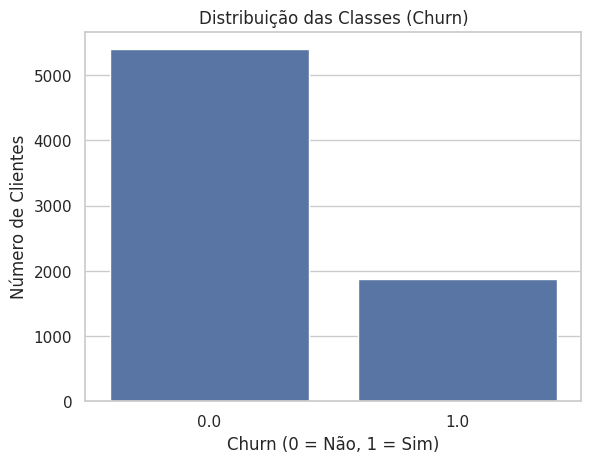

In [2]:
# Distribuição das classes
churn_counts = df['Churn'].value_counts(normalize=True)
print("Distribuição das classes:")
print(churn_counts)

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.title('Distribuição das Classes (Churn)')
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Número de Clientes')
plt.show()


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separação de variáveis
X = df.drop('Churn', axis=1)
y = df['Churn']

# Codificação one-hot
X = pd.get_dummies(X, drop_first=True)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Aplica SMOTE no treino
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [ ]:
df_corr = X.copy()
df_corr['Churn'] = y
corr = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr[['Churn']].sort_values(by='Churn', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlação com Churn')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelo 1: Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_res_scaled, y_train_res)

# Modelo 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Regressão Logística
print("=== Regressão Logística ===")
y_pred_log = log_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

# Random Forest
print("\n=== Random Forest ===")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


In [ ]:
importances = rf_model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title('Top 10 Variáveis Mais Relevantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()


###Conclusão

- A **Random Forest** teve melhor desempenho na previsão de churn.
- Variáveis como `Contract`, `MonthlyCharges`, `Tenure`, `OnlineSecurity`, `TechSupport` foram as mais importantes.
- Clientes com contratos mensais, pouco tempo de casa e sem suporte estão mais propensos à evasão.

 **Recomendações de retenção:**
- Estimular contratos mais longos com incentivos.
- Monitorar clientes novos com altos valores de cobrança.
- Oferecer serviços adicionais (segurança, suporte) como bônus.
